### Some phoney experiments to do ND Gaussian Process regression with scikit-learn.
gully

In [1]:
%matplotlib inline

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:48: RuntimeWarning: covariance is not positive-semidefinite.
//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


best-fit theta = 10.0


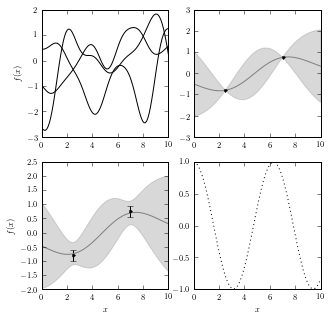

In [16]:
# %load http://www.astroml.org/_downloads/fig_gp_example.py
"""
Gaussian Process Example
------------------------
Figure 8.10

An example of Gaussian process regression. The upper-left panel shows three
functions drawn from an unconstrained Gaussian process with squared-exponential
covari- ance of bandwidth h = 1.0. The upper-right panel adds two constraints,
and shows the 2-sigma contours of the constrained function space. The
lower-left panel shows the function space constrained by the points with error
bars. The lower-right panel shows the function space constrained by 20 noisy
points drawn from f(x) = cos(x).
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcess

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

#------------------------------------------------------------
# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100)
h = 1.0

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)
gp1 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      random_state=0)
gp1.fit(x1[:, None], y1)
f1, MSE1 = gp1.predict(x[:, None], eval_MSE=True)
f1_err = np.sqrt(MSE1)

#------------------------------------------------------------
# Constrain the mean and covariance with two noisy points
#  scikit-learn gaussian process uses nomenclature from the geophysics
#  community, where a "nugget" can be specified.  The diagonal of the
#  assumed covariance matrix is multiplied by the nugget.  This is
#  how the error on inputs is incorporated into the calculation
dy2 = 0.2
gp2 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      nugget=(dy2 / y1) ** 2, random_state=0)
gp2.fit(x1[:, None], y1)
f2, MSE2 = gp2.predict(x[:, None], eval_MSE=True)
f2_err = np.sqrt(MSE2)


#------------------------------------------------------------
# Constrain the mean and covariance with many noisy points
xx3 = np.linspace(0, 10, 20)
zz3 = np.linspace(0, 10, 20)
x3, z3 = np.meshgrid(xx3, zz3)

y3 = np.cos(x3)*np.sin(z3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)
gp3 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      thetaL=0.01, thetaU=10.0,
                      nugget=(dy3 / y3) ** 2,
                      random_state=0)

#big_X = np.vstack((x3, z3)).T
big_X = np.hstack((x3.reshape(20*20, 1), z3.reshape(20*20, 1))).shape
gp3.fit(big_X, y3)
X_pred = np.vstack((x, x)).T
f3, MSE3 = gp3.predict(X_pred, eval_MSE=True)
f3_err = np.sqrt(MSE3)

# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gp3.theta_[0, 0])


#------------------------------------------------------------
# Plot the diagrams
fig = plt.figure(figsize=(5, 5))


# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, '-k')
ax.set_ylabel('$f(x)$')

# second: plot a constrained function
ax = fig.add_subplot(222)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * f1_err, f1 + 2 * f1_err, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)


# third: plot a constrained function with errors
ax = fig.add_subplot(223)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * f2_err, f2 + 2 * f2_err, color='gray', alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt='.k', ms=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

# Fourth
ax = fig.add_subplot(224)
#ax.plot(x, f3, '-', color='gray')
#ax.fill_between(x, f3 - 2 * f3_err, f3 + 2 * f3_err, color='gray', alpha=0.3)
#ax.errorbar(x3, y3, dy3, fmt='.k', ms=6)

ax.plot(x, np.cos(x), ':k')

ax.set_xlabel('$x$')

for ax in fig.axes:
    ax.set_xlim(0, 10)

plt.show()


In [49]:
xx3 = np.linspace(0, 10, 20)
zz3 = np.linspace(0, 10, 20)
x3, z3 = np.meshgrid(xx3, zz3)

y3 = np.cos(x3)*np.sin(z3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)

big_X = np.hstack((x3.reshape(20*20, 1), z3.reshape(20*20, 1)))
X_in = big_X
y_in = y3.reshape(20*20, 1).squeeze()

gp3 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      thetaL=0.01, thetaU=10.0,
                      nugget=(dy3 / y_in) ** 2,
                      random_state=0)

#big_X = np.vstack((x3, z3)).T

print(X_in.shape, y_in.shape)
gp3.fit(X_in, y_in)

(400, 2) (400,)


GaussianProcess(beta0=None,
        corr=<function squared_exponential at 0x10d586158>, normalize=True,
        nugget=array([ 0.7758 ,  0.6173 , ...,  0.09472,  0.25904]),
        optimizer='fmin_cobyla', random_start=1,
        random_state=<mtrand.RandomState object at 0x1129c0be0>,
        regr=<function constant at 0x10c3d3d90>, storage_mode='full',
        theta0=array([[ 0.5]]), thetaL=array([[ 0.01]]),
        thetaU=array([[ 10.]]), verbose=False)

In [51]:
x_p = np.linspace(0, 10, 100)

In [52]:
x3p, z3p = np.meshgrid(x_p, x_p)

In [ ]:
big_X = np.hstack((x3.reshape(20*20, 1), z3.reshape(20*20, 1)))

In [56]:
X_pred = np.hstack((x3p.reshape(100*100, 1), z3p.reshape(100*100, 1)))

In [60]:
f3, MSE3 = gp3.predict(X_pred, eval_MSE=True)
f3_err = np.sqrt(MSE3)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


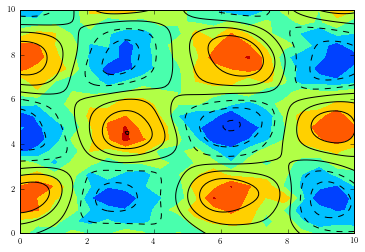

In [66]:
plt.contourf(x3,z3,y3)
plt.contour(x3p, z3p, f3.reshape(100,100), colors='k')